In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim

from scipy.linalg import sqrtm
from statsmodels.stats.correlation_tools import cov_nearest
from torchdiffeq import odeint

from external_drift import (ScenarioParams, generate_training_set, 
                            get_mean_tensor_from_training_set, get_multivariate_batch)
from ml import KramersMoyal, load_kernels_dict
from neural_ode import ODEfunc, RunningAverageMeter
from plot import ImperialColors, plot_simulation
from plot.external_drift import plot_training_evaluation
from potenciala import BucketMethod, VectorTimeSeries
from stochastic import (EulerMaruyama, SpatialNearestDriftMultivariate, ConstantDiffusionMultivariate)

In [3]:
df_raw = pd.read_csv("day_ahead_market_20211005.csv")
df_raw["spain"] = df_raw["spain"].round(decimals=2)

In [4]:
df = df_raw.query("year >= 2004 & year <= 2020")

### Load VectorTimeSeries and drift and diffusion coefficients

In [5]:
s_kde = VectorTimeSeries(df=df, signal_name="spain", bucket_method=BucketMethod.NoBucket)

d_1_dict = load_kernels_dict(path="data/kde/d_1/", pattern="d_1_(.*)_1000_1000", dim_num=1)
expected_drift_kde_df = KramersMoyal.obtain_first_coefficient_vector(kernels_dict=d_1_dict)

d_2_diag_dict = load_kernels_dict(path="data/kde/d_2_diag/", pattern="d_2_diag_(.*)_1000_1000", dim_num=1)
d_2_non_diag_dict = load_kernels_dict(
    path="data/kde/d_2_non_diag/", pattern="d_2_non_diag_(.*)_100_100", dim_num=2
)
second_km_kde_matrix = KramersMoyal.obtain_second_coefficient_matrix(diag_kernels_dict=d_2_diag_dict, 
                                                                     non_diag_kernels_dict=d_2_non_diag_dict)

drift_kde = SpatialNearestDriftMultivariate(df=expected_drift_kde_df)

sqrt_diff_matrix_kde = sqrtm(cov_nearest(cov=2*second_km_kde_matrix, threshold=1e-14))
cte_diffusion_kde = ConstantDiffusionMultivariate(df=pd.DataFrame(sqrt_diff_matrix_kde))

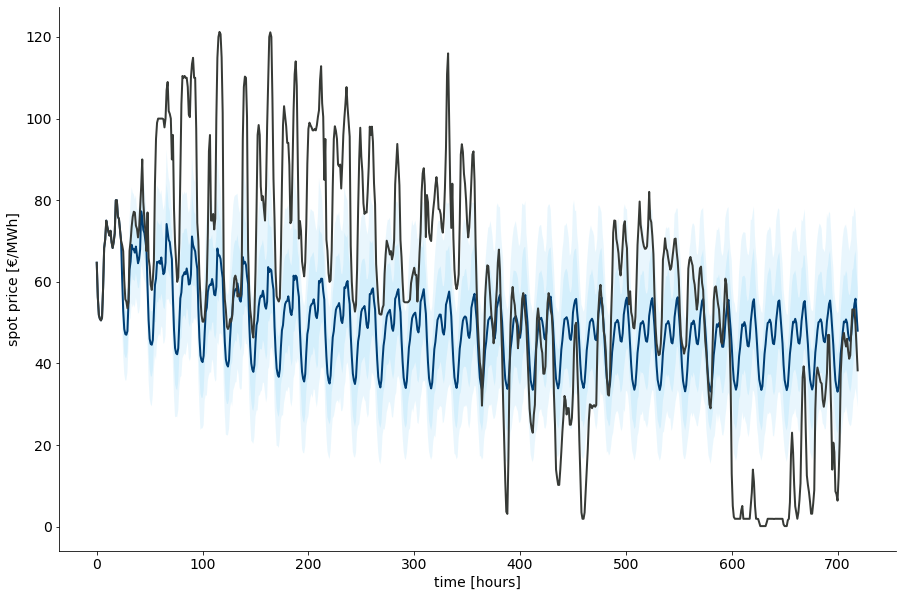

In [6]:
scenario_params = ScenarioParams(sim_periods=30, 
                                 n_sim=1_000, 
                                 delta_t=1, 
                                 seed=1_024, 
                                 batch_size=30, 
                                 obs_dim=24,
                                 epochs=2_000)

x_df = df_raw[df_raw["date"] >= "2021-01-05"].iloc[:24*scenario_params.sim_periods]
x_df_kde = x_df.copy(deep=True)
x_0 = x_df["spain"].iloc[:24].values

em = EulerMaruyama(num_sim=scenario_params.n_sim, 
                   periods=scenario_params.sim_periods, 
                   delta_t=scenario_params.delta_t, 
                   nu=0, 
                   drift=drift_kde, 
                   diffusion=cte_diffusion_kde)

sim_df = em.simulate(x0=x_0, random_seed=scenario_params.random_seed)

sim_dict = {"sim_df": sim_df, "actual_df": x_df_kde}
plot_simulation(sim_dict=sim_dict)

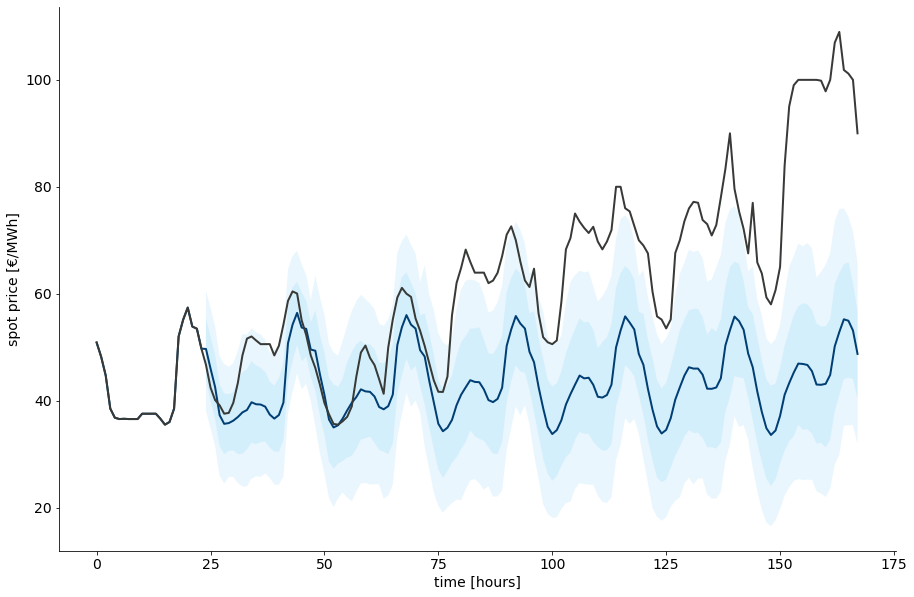

In [7]:
scenario_params = ScenarioParams(sim_periods=7, 
                                 n_sim=1_000, 
                                 delta_t=1, 
                                 seed=1_024, 
                                 batch_size=30, 
                                 obs_dim=24,
                                 epochs=2_000)

x_df = df_raw[df_raw["date"] >= "2021-01-01"].iloc[:24*scenario_params.sim_periods]
x_df_kde = x_df.copy(deep=True)
x_0 = x_df["spain"].iloc[:24].values

em = EulerMaruyama(num_sim=scenario_params.n_sim, 
                   periods=scenario_params.sim_periods, 
                   delta_t=scenario_params.delta_t, 
                   nu=0, 
                   drift=drift_kde, 
                   diffusion=cte_diffusion_kde)

sim_df = em.simulate(x0=x_0, random_seed=scenario_params.random_seed)

sim_dict = {"sim_df": sim_df, "actual_df": x_df_kde}
plot_simulation(sim_dict=sim_dict)

### Compute difference between simulation and external drift to generate training set

In [8]:
hour_ts_diff_df = generate_training_set(sim_df=sim_df, 
                                        actual_series=x_df_kde.reset_index()["spain"], 
                                        params=scenario_params)

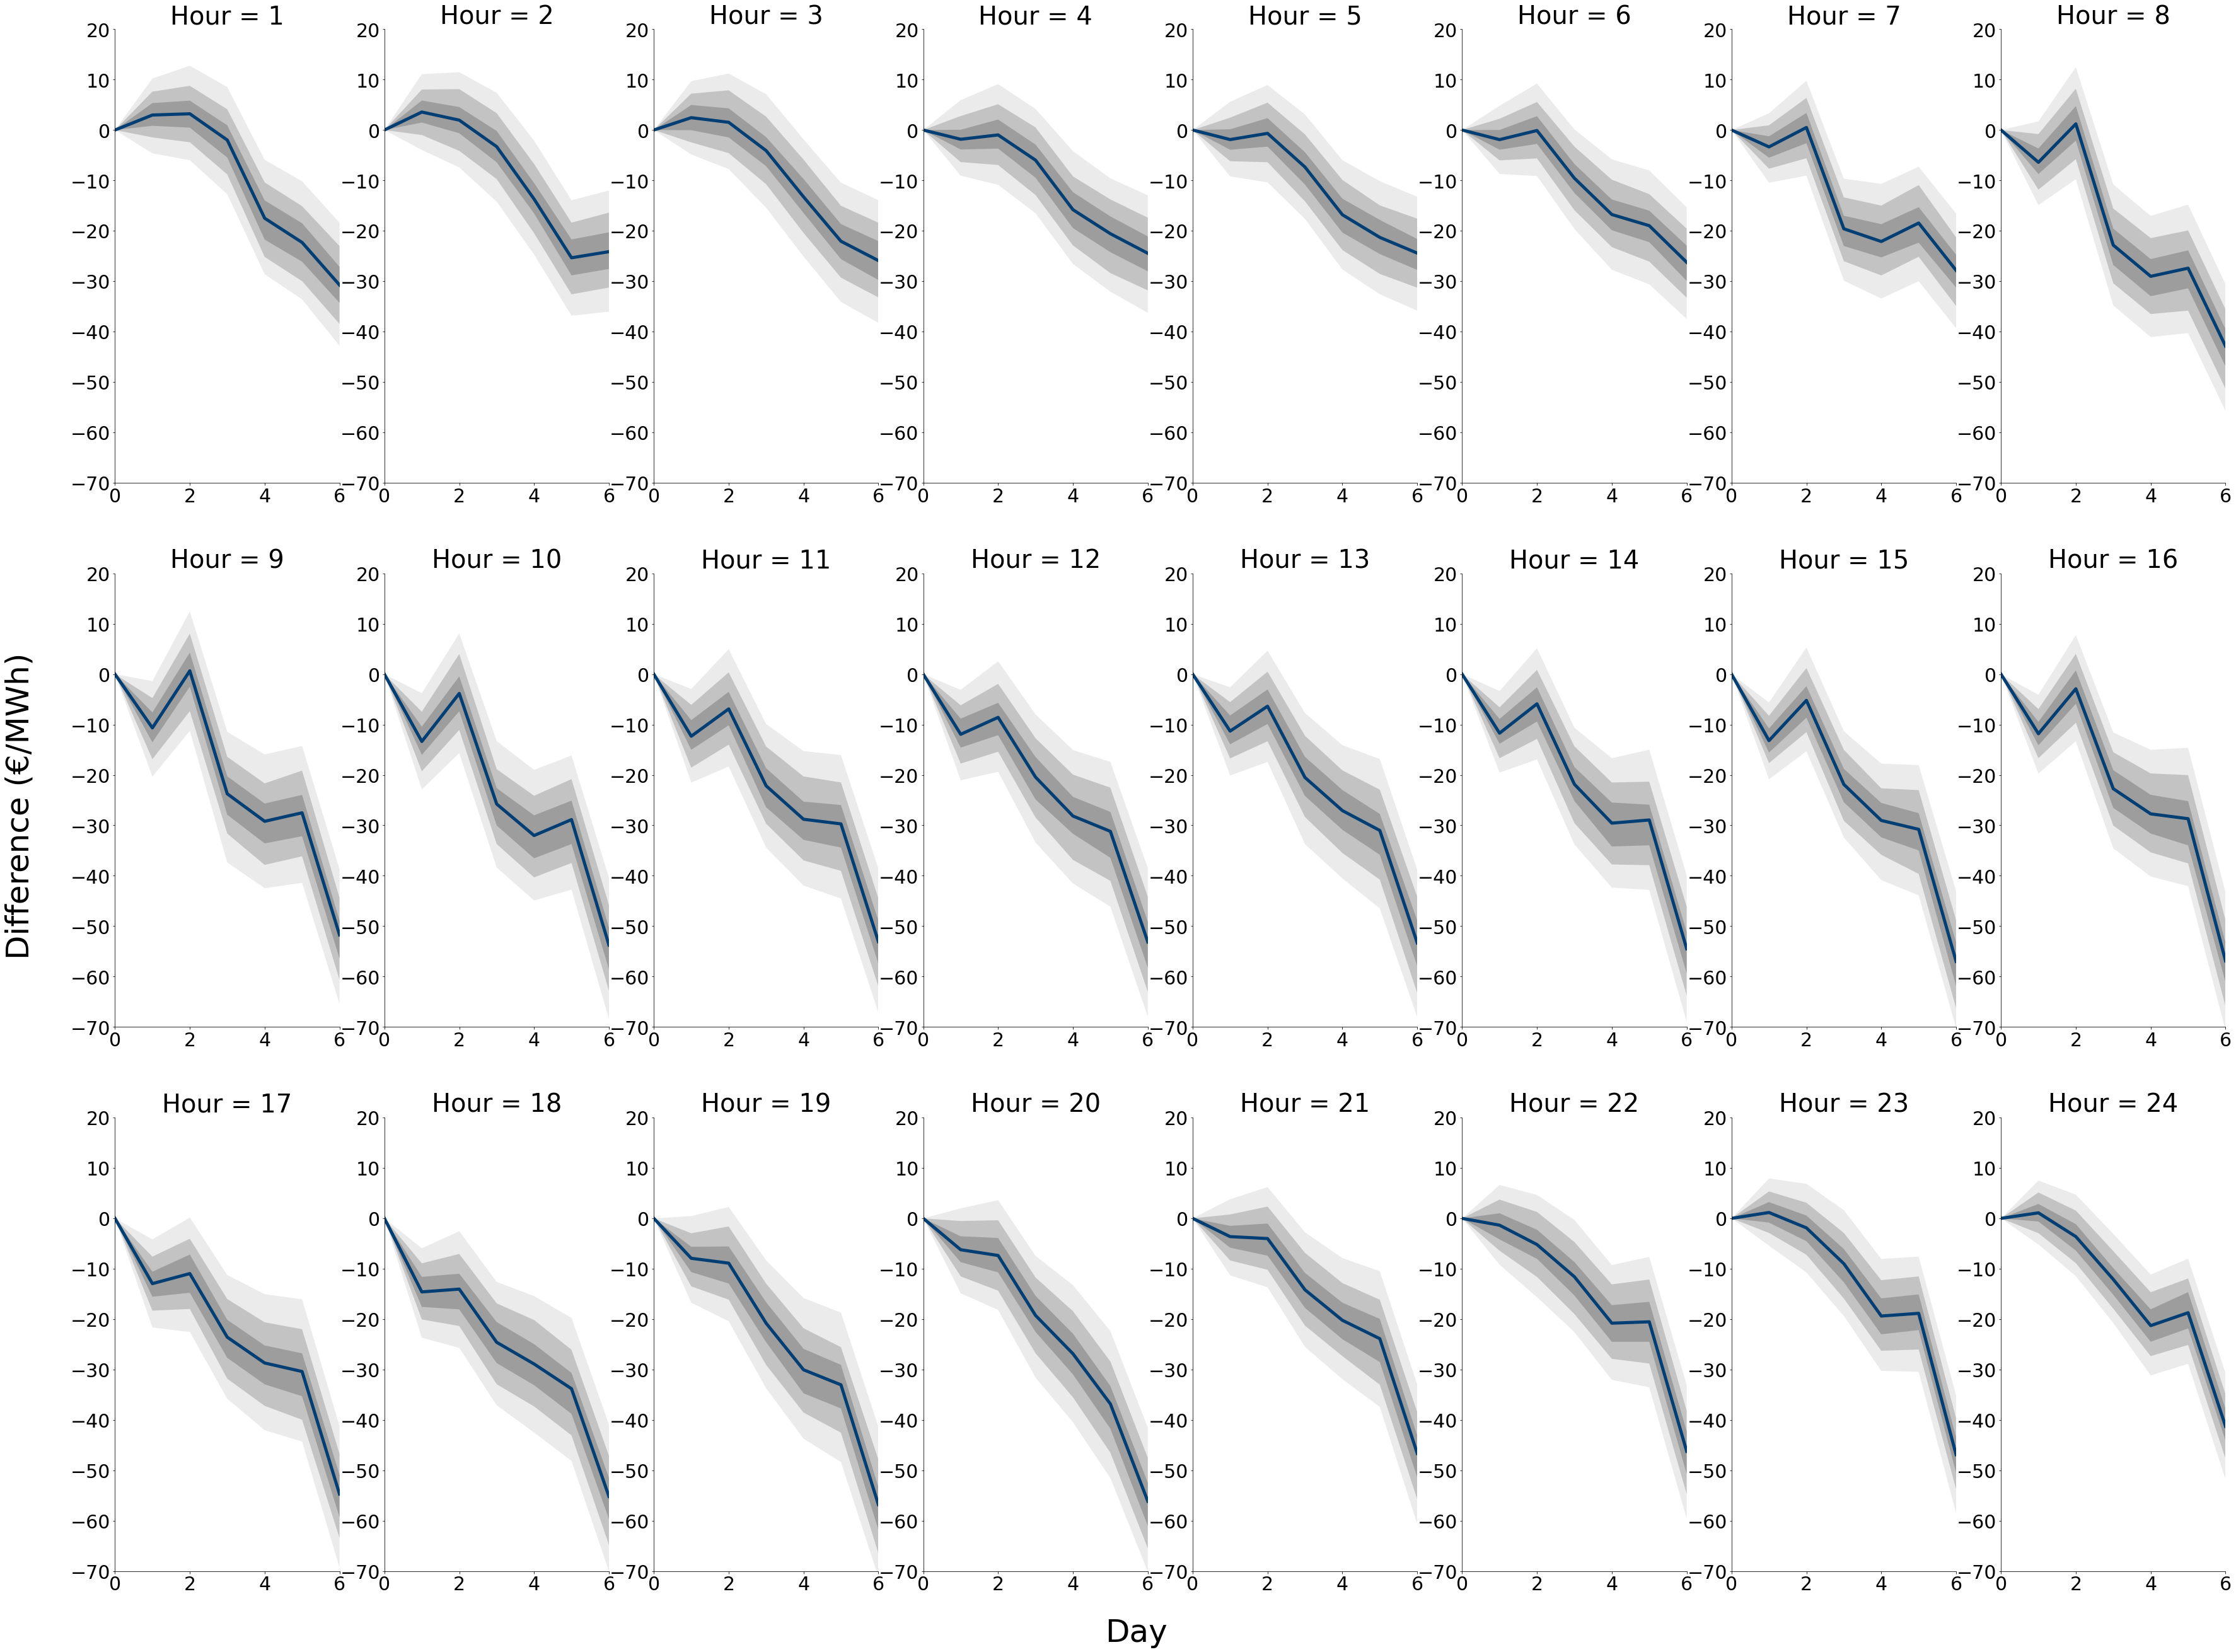

In [9]:
fig, axis = plt.subplots(3, 8, figsize=(60, 45))
percentiles_alpha = [0.2, 0.5, 1]
quantile = [0.2, 0.3, 0.4, 0.6, 0.7, 0.8]

for i, ax_list in enumerate(axis):
    for j, ax in enumerate(ax_list):
        h = 1 + i*8+j
        hour_ts_diff_df.loc[h].mean(axis=1).plot(ax=ax, lw=5, color=ImperialColors.blue.value)
        
        percentile_df = hour_ts_diff_df.loc[h].quantile(q=quantile, axis=1)
        for k, alpha_value in enumerate(percentiles_alpha):            
            ax.fill_between(
                percentile_df.columns, 
                percentile_df.loc[quantile[k]], 
                percentile_df.loc[quantile[-k-1]],
                facecolor=ImperialColors.cool_grey.value, 
                alpha=alpha_value
            )
        ax.set_xlabel("")
        ax.set_title(f"Hour = {h}", fontsize=40)
        ax.set_xlim(0, scenario_params.sim_periods-1)
        ax.set_ylim(-70, 20)
        ax.tick_params(axis="both", labelsize=30)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
fig.text(0.5, 0.095, "Day", ha="center", va="center", fontdict={"size": 50})
fig.text(0.09, 0.5, "Difference (€/MWh)", ha="center", va="center", fontdict={"size": 50}, rotation=90)
plt.show()

### Train simple neural ODE to learn external drift

In [ ]:
def plot_training_evaluation(pred_tensor: torch.tensor, train_df: pd.DataFrame, training_ts: int):
    fig, axis = plt.subplots(3, 8, figsize=(60, 45))

    pred_df = pd.DataFrame(pred_tensor.reshape(-1, 24).T, index=np.arange(1, 25))
    
    for i, ax_list in enumerate(axis):
        for j, ax in enumerate(ax_list):
            h = 1 + i*8+j
            hour_ts_diff_df.loc[h].mean(axis=1).plot(ax=ax, lw=5, color=ImperialColors.blue.value)
            pred_df.loc[h].plot(ax=ax, lw=5, color=ImperialColors.dark_green.value)
            ax.axvline(x=training_ts, color=ImperialColors.cool_grey.value)
    
            ax.set_xlabel("")
            ax.set_title(f"Hour = {h}", fontsize=40)
            ax.set_xlim(0, pred_df.shape[-1])
            ax.set_ylim(-70, 10)
            ax.tick_params(axis="both", labelsize=30)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
    fig.text(0.5, 0.095, "Day", ha="center", va="center", fontdict={"size": 50})
    fig.text(0.09, 0.5, "Difference (€/MWh)", ha="center", va="center", fontdict={"size": 50}, rotation=90)

Training time step 5 - Iteration: 0000 | Total loss 15.597359 | Time: 0.00 mins


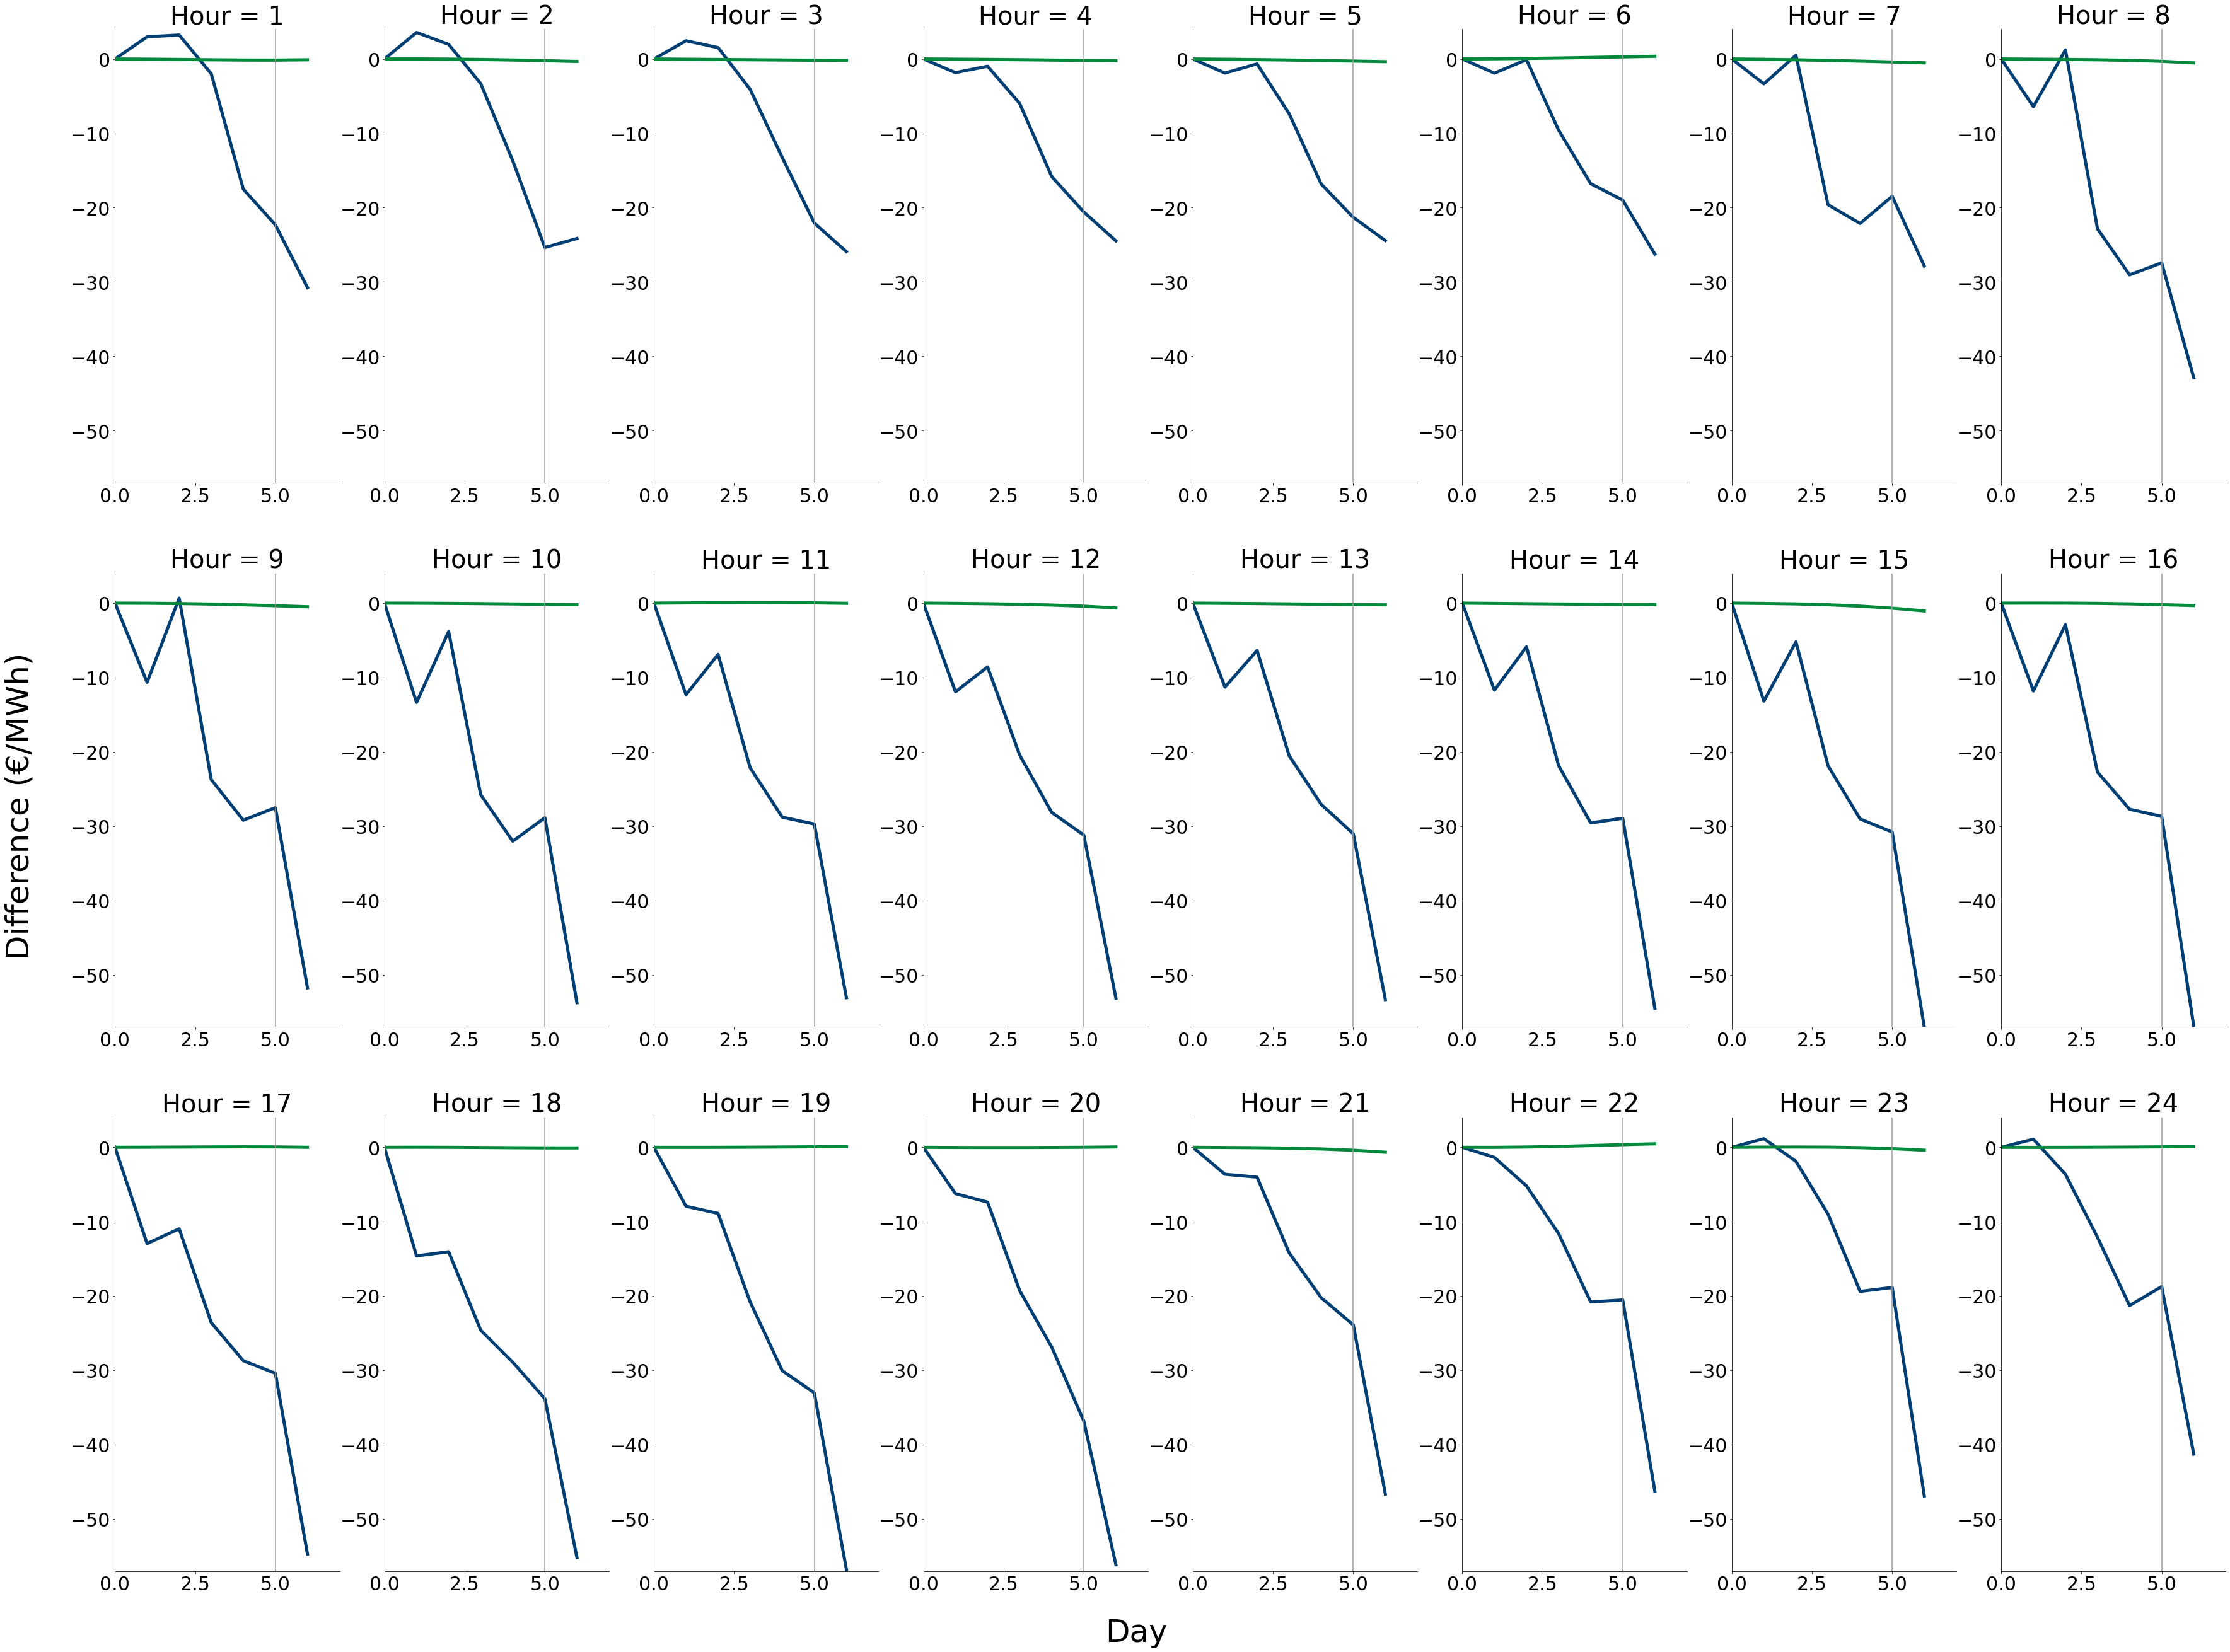

Mean absolute value error for test: 44.10


Training time step 5 - Iteration: 0250 | Total loss 9.201625 | Time: 0.36 mins
Training time step 5 - Iteration: 0500 | Total loss 9.208435 | Time: 0.69 mins
Training time step 5 - Iteration: 0750 | Total loss 9.221716 | Time: 1.04 mins
Training time step 5 - Iteration: 1000 | Total loss 9.098106 | Time: 1.40 mins


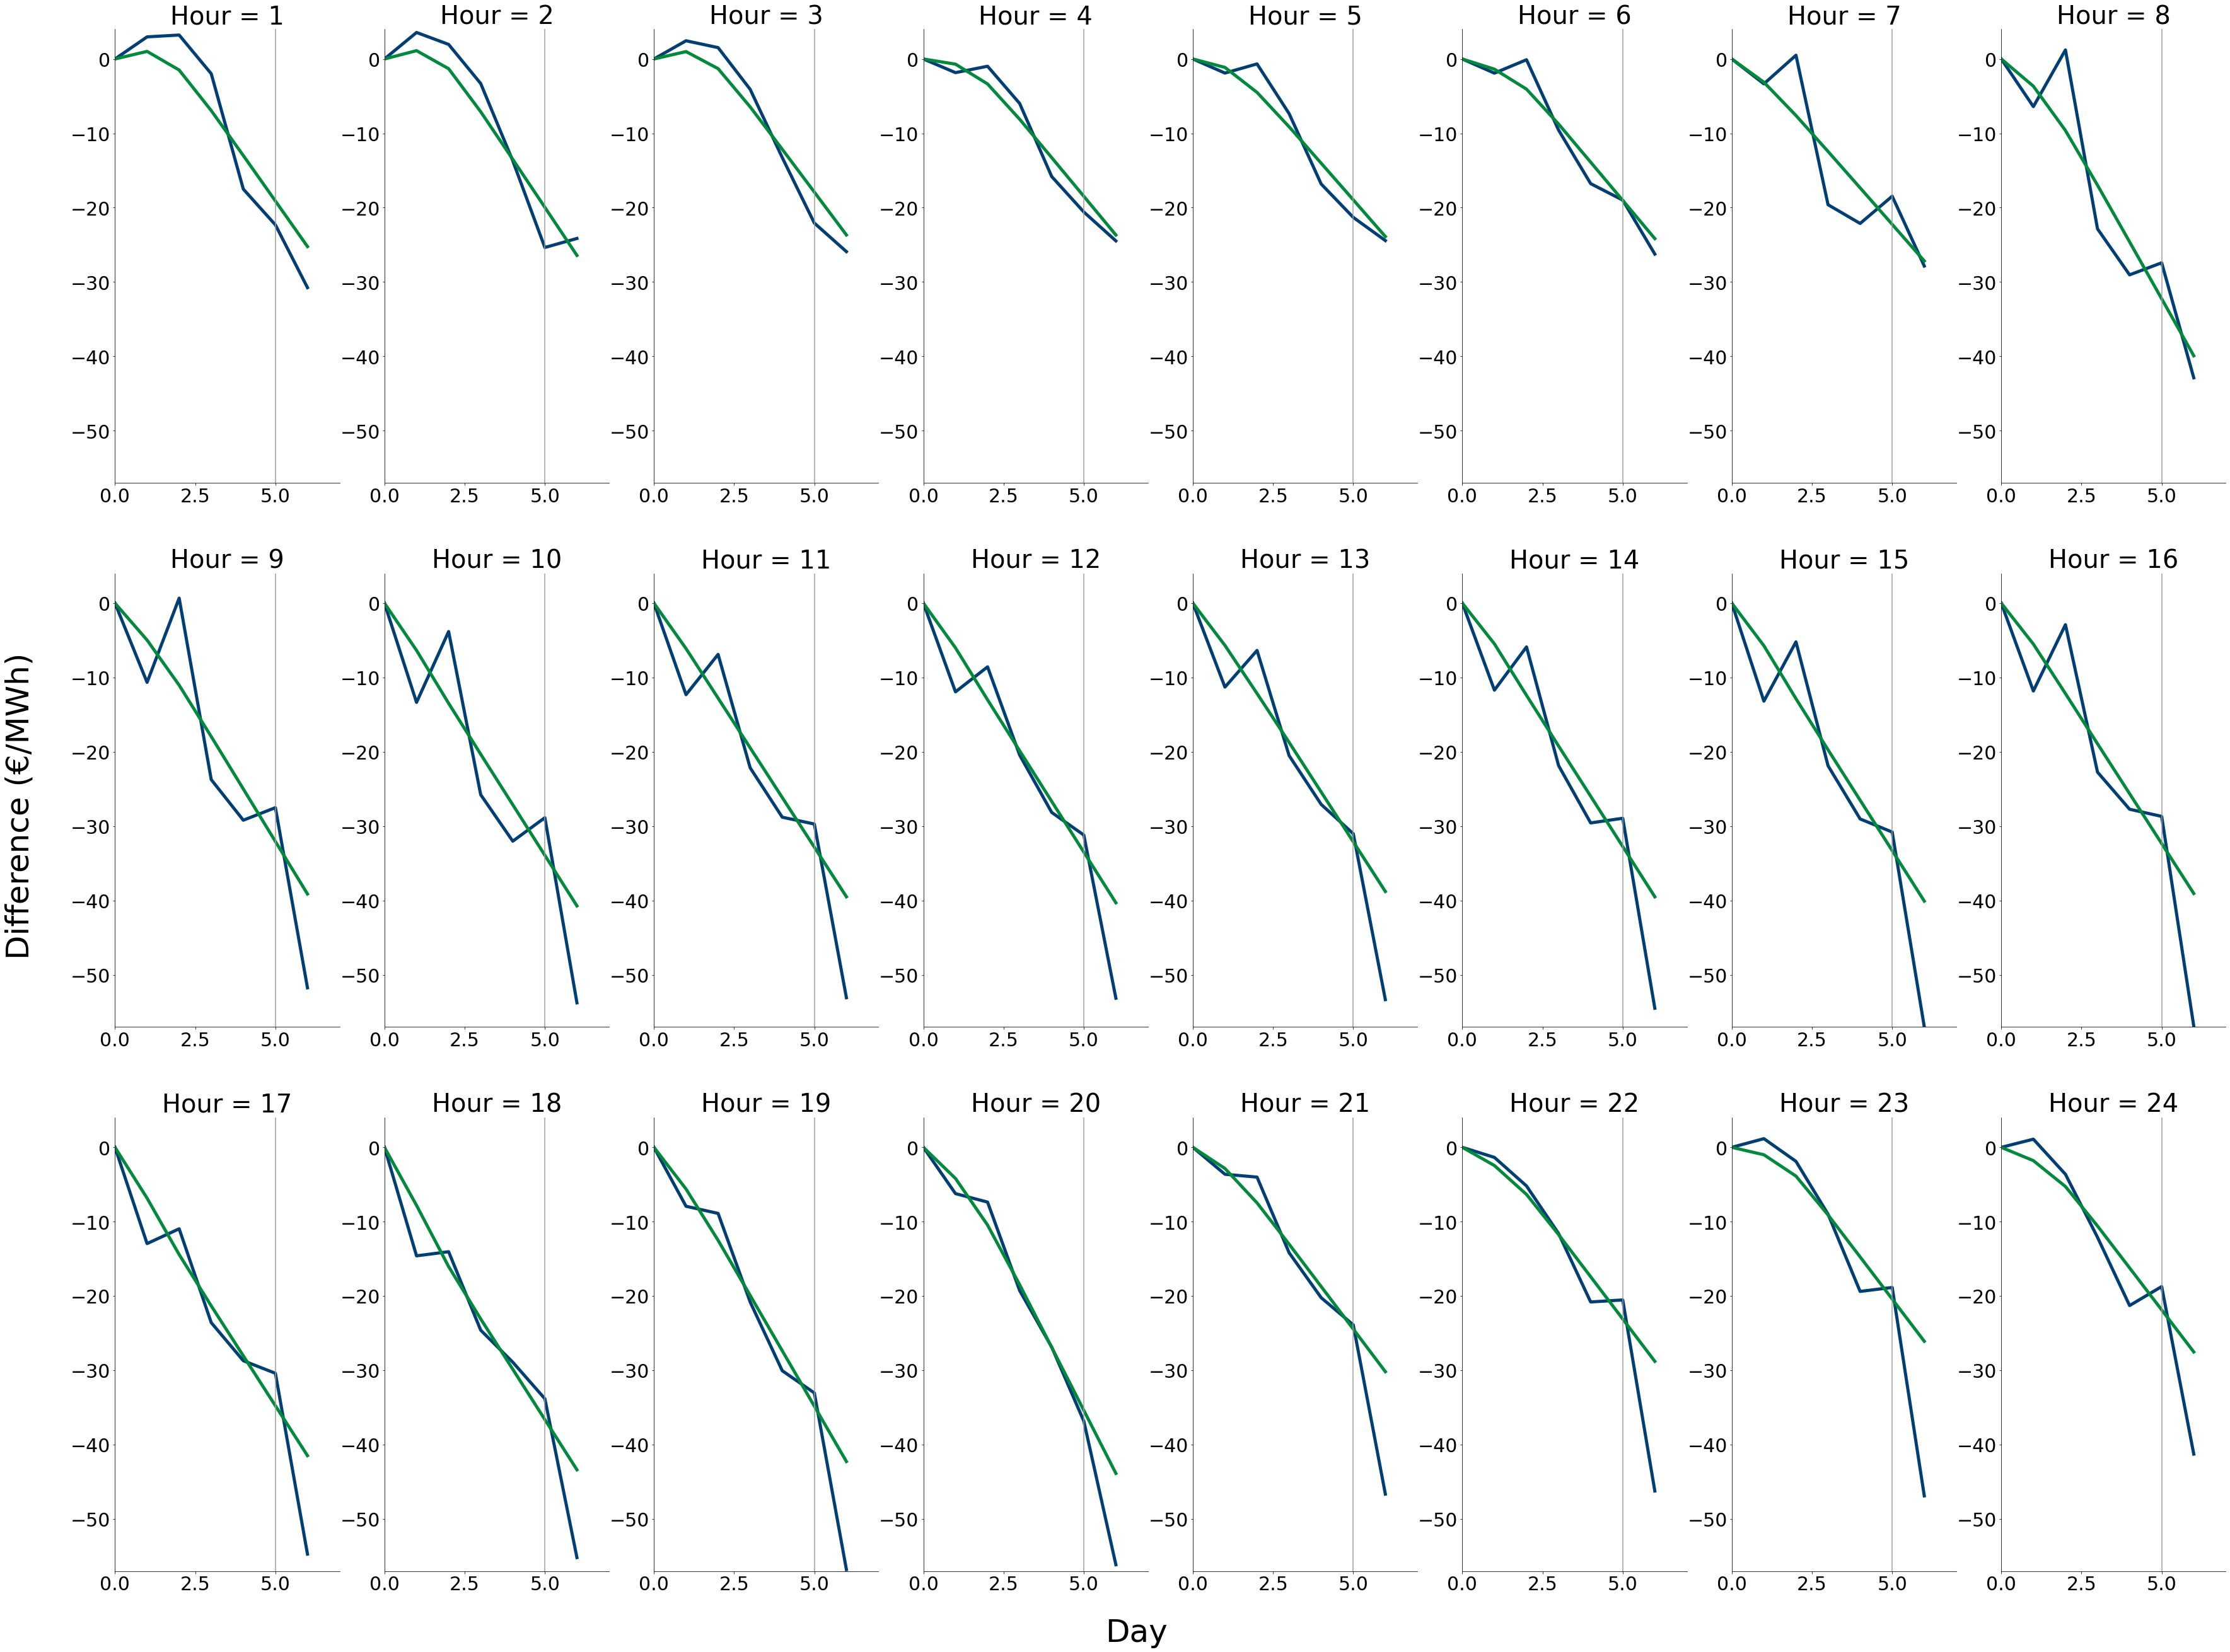

Mean absolute value error for test: 10.57


Training time step 5 - Iteration: 1250 | Total loss 8.996661 | Time: 1.83 mins
Training time step 5 - Iteration: 1500 | Total loss 9.074625 | Time: 2.25 mins
Training time step 5 - Iteration: 1750 | Total loss 9.022752 | Time: 2.70 mins
Training time step 5 - Iteration: 2000 | Total loss 9.009856 | Time: 3.17 mins


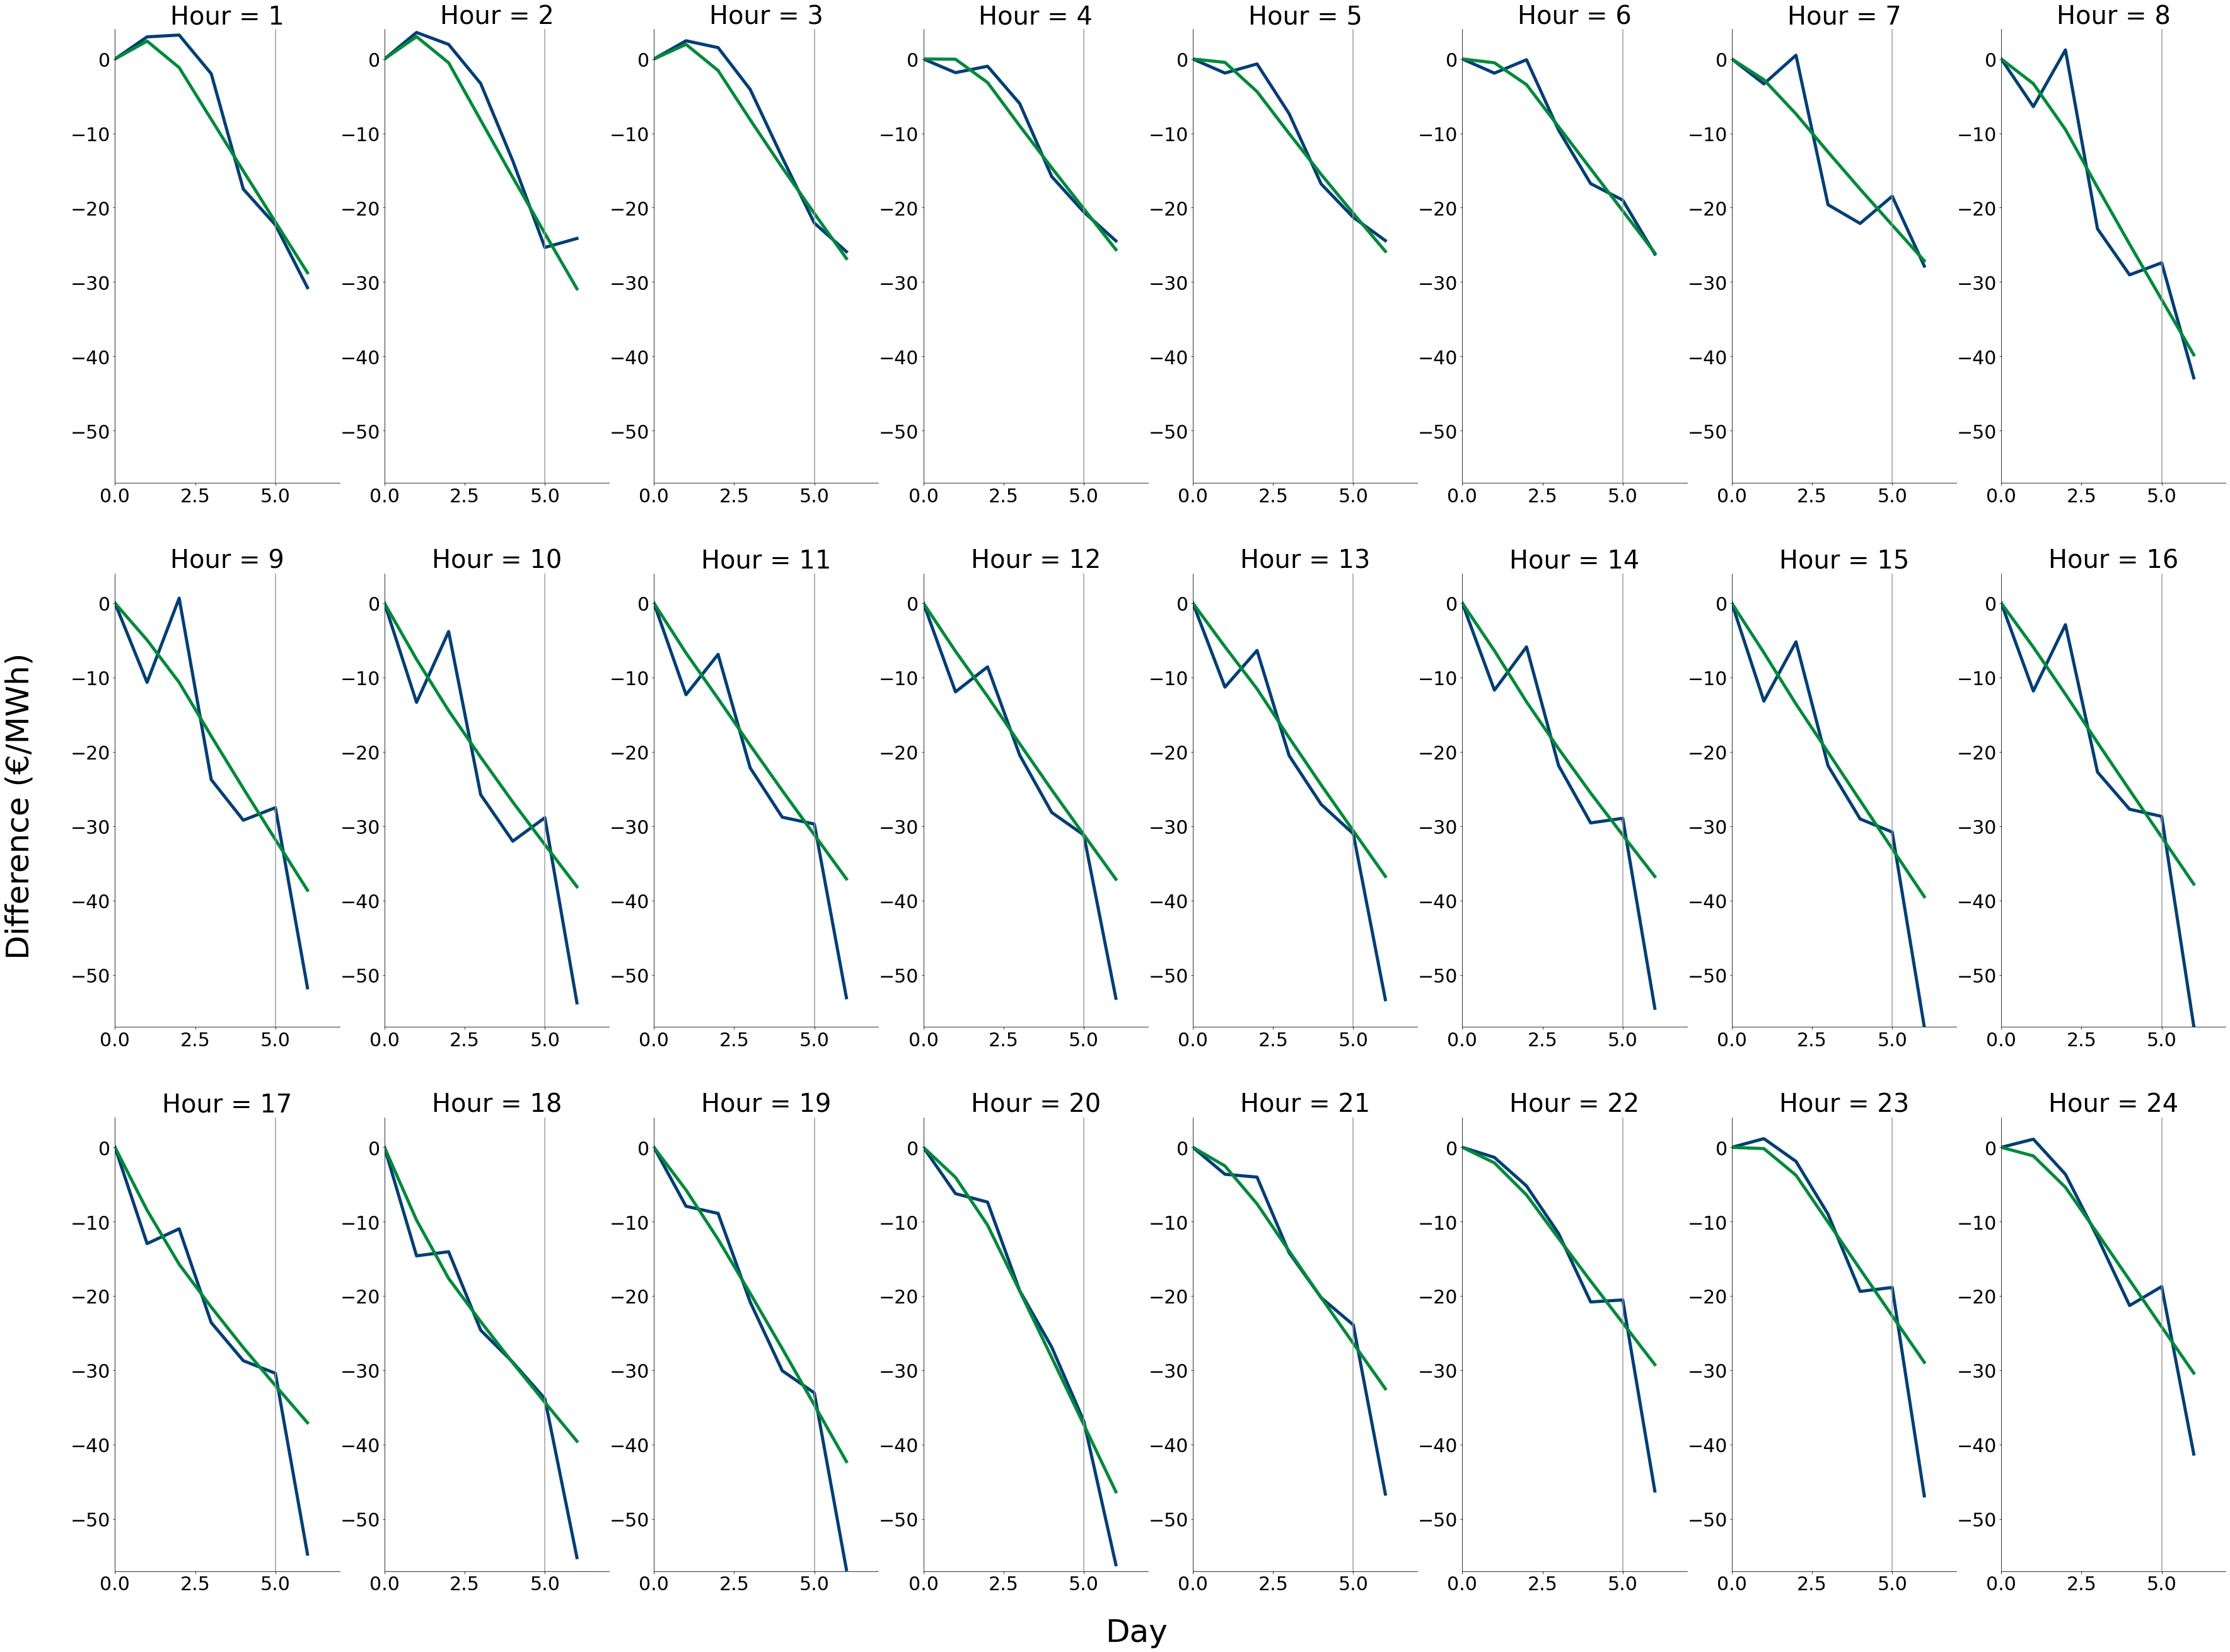

Mean absolute value error for test: 11.07




In [14]:
device = torch.device("cpu")

pred_ext_drift_dict ={}

init_window_length = 0

func = ODEfunc(obs_dim=scenario_params.obs_dim, hidden_layer_1=96).to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

start = time.time()
for j in range(5, scenario_params.sim_periods-1):
    training_ts = init_window_length + scenario_params.delta_t*j

    loss_meter = RunningAverageMeter(0.97)
    
    for itr in range(0, scenario_params.epochs+1):
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_multivariate_batch(train_df=hour_ts_diff_df, 
                                                            time_period=training_ts,
                                                            params=scenario_params)
        batch_y0 = batch_y0.to(device)
        batch_t = batch_t.to(device)
        batch_y = batch_y.to(device)

        pred_y = odeint(func, batch_y0, batch_t).to(device)

        loss = torch.mean(torch.abs(pred_y - batch_y))
        loss.backward()
        optimizer.step()

        loss_meter.update(loss.item())
        end = time.time()
        training_time = (end-start) / 60

        if itr % 250 == 0:
            print(f"Training time step {j} - Iteration: {itr:04d} | Total loss {loss_meter.avg:.6f} | Time: {training_time:.2f} mins")
        
        if itr % 1_000 == 0:
            # evaluate training and test set
            true_y0 = get_mean_tensor_from_training_set(train_df=hour_ts_diff_df, time_step=0).to(device)
            batch_test_t = torch.from_numpy(np.arange(training_ts+2, dtype=np.float64))
            true_test_y = get_mean_tensor_from_training_set(train_df=hour_ts_diff_df, time_step=training_ts+1).to(device)
            with torch.no_grad():
                pred_test_y = odeint(func, true_y0, batch_test_t)
                plot_training_evaluation(pred_tensor=pred_test_y, 
                                         train_df=hour_ts_diff_df, 
                                         training_ts=training_ts,
                                         params=scenario_params,
                                         rows=3,
                                         columns=8)
                plt.show()
                test_loss = torch.mean(torch.abs(true_test_y - pred_test_y[-1]))
                print(f"Mean absolute value error for test: {test_loss:.2f}")
                if itr == 2_000:
                    pred_ext_drift_dict[training_ts] = pred_test_y
            
            print("\n" + "="*115 + "\n")

### Add learnt external drift to simulated trajectories

In [ ]:
for k, pred_tensor in pred_ext_drift_dict.items():
    node_ext_drift = pd.Series(pred_tensor.reshape(k+2, 24).flatten())
    sim_ext_drift_df = sim_df.subtract(node_ext_drift, axis="index").dropna()
    
    sim_dict = {"sim_df": sim_ext_drift_df, "actual_df": x_df_kde}
    plot_simulation(sim_dict=sim_dict)

### Train 24 simple neural ODEs to learn external drift

In [ ]:
def train_neural_ode_step(k: int, 
                          neural_odes_dict: dict, 
                          optimizer_dict: dict,
                          loss_meter_dict: dict,
                          batch_y0: torch.tensor, 
                          batch_y: torch.tensor  
                          ):
    optimizer_dict[k].zero_grad()
            
    y0 = batch_y0[:, :, k-1].reshape(30, 1, 1)
    y = batch_y[:, :, :, k-1].reshape(-1, 30, 1, 1)
            
    pred_y = odeint(neural_odes_dict[k], y0, batch_t).to(device)
            
    loss = torch.mean(torch.abs(pred_y - y))
    loss.backward()
    optimizer_dict[k].step()
            
    loss_meter_dict[k].update(loss.item())
    
    return (k, neural_odes_dict[k], optimizer_dict[k], loss_meter_dict[k])
    

In [ ]:
device = torch.device("cpu")

pred_ext_drift_dict ={}

init_window_length = 0
time_step = 1

neural_odes_dict = {}
optimizer_dict = {}
for k in range(1, 25):
    func = ODEfunc(obs_dim=1, hidden_layer_1=24*4).to(device)
    neural_odes_dict[k] = func
    optimizer_dict[k] = optim.RMSprop(func.parameters(), lr=1e-3)

start = time.time()
for j in range(1, 7):
    training_ts = init_window_length + time_step*j
    
    loss_meter_dict = {k : RunningAverageMeter(0.97) for k in range(1, 25)}
    
    for itr in range(0, 2_000+1):
        batch_y0, batch_t, batch_y = get_multivariate_batch(train_df=hour_ts_diff_df, time_step=training_ts)
        batch_y0 = batch_y0.to(device)
        batch_t = batch_t.to(device)
        batch_y = batch_y.to(device)
            
        train_step_list = Parallel(n_jobs=-1, verbose=0)(
            delayed(train_neural_ode_step)(
                k=k, neural_odes_dict=neural_odes_dict, optimizer_dict=optimizer_dict, 
                loss_meter_dict=loss_meter_dict, batch_y0=batch_y0, batch_y=batch_y
            ) for k in range(1, 25)
        )
        for element in train_step_list:
            k = element[0]
            neural_odes_dict[k] = element[1]
            optimizer_dict[k] = element[2]
            loss_meter_dict[k] = element[3]
            
            
        end = time.time()
        training_time = (end-start) / 60
        if itr % 250 == 0:
            loss_array = np.array([v.avg for k, v in loss_meter_dict.items()])
            loss_mean = loss_array.mean()
            print(f"Training time step {j} - Iteration: {itr:04d} | Total loss {loss_mean:.6f} | Time: {training_time:.2f} mins")

        if itr % 1_000 == 0:
            true_y0 = get_mean_tensor_from_trajectories(traj_df=hour_ts_diff_df, time_step=0)
            batch_test_t = torch.from_numpy(np.arange(training_ts+2, dtype=np.float64))
            true_test_y = get_mean_tensor_from_trajectories(traj_df=hour_ts_diff_df, time_step=training_ts+1)
            
            with torch.no_grad():
                pred_test_y_list = []
                for k in range(1, 25):
                    pred_test_y_k = odeint(neural_odes_dict[k], true_y0[:, :, k-1].reshape(1, 1, 1), batch_test_t)
                    pred_test_y_list.append(pred_test_y_k)
                pred_test_y = torch.hstack(pred_test_y_list).reshape(training_ts+2, 1, 1, -1)
                plot_training_evaluation(pred_tensor=pred_test_y, train_df=hour_ts_diff_df, training_ts=training_ts)
                plt.show()
                test_loss = torch.mean(torch.abs(true_test_y - pred_test_y[-1]))
                print(f"Mean absolute value error for test: {test_loss:.2f}")
                if itr == 2_000:
                    pred_ext_drift_dict[training_ts] = pred_test_y
            
            print("\n" + "="*115 + "\n")
                

Ideas to explore:
 - Try more elaborated neural network architecture
 - Expand test time range
 - Train 1 latent neural ODE of 24 input dimensions
 - Train 24 latent neural ODEs of 1 input dimension
 - Classic ML (splines, boosting, gaussian mixture model) regressor inside a numerical integrator